In [63]:
s3_data ="s3://aegovan-data/processed_dataset/test_unique_negative_entity_only.json"
model_s3_path="s3://aegovan-data/results/ppi-bert-untype-2019-11-05-08-14-14-416/output/output.tar.gz"

s3_model_path_format = "s3://aegovan-data/results/{}/output/output.tar.gz"

In [20]:
!pip install scikit-plot==0.3.7

awsebcli 3.12.4 has requirement requests<=2.9.1,>=2.6.1, but you'll have requests 2.20.1 which is incompatible.
spacy 2.1.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.1 which is incompatible.
blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tarfile
import pandas as pd
import json
from pandas.io.json import json_normalize
import tempfile 
import os
import boto3
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
import scikitplot as skplt





In [3]:


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [4]:

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [5]:
def load_scores_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)

In [6]:


def get_predictions(s3_path):
    tmp_dir = tempfile.mkdtemp()
    outfile = os.path.join(tmp_dir, "output.tar.gz" )
    download_single_file(s3_path, outfile)
    tf = tarfile.open(outfile)
    tf.extractall(path=tmp_dir)
    test_input_file = os.path.join(tmp_dir, "predicted.json")


    df_results =  pd.read_json(test_input_file)
    df_results["actual"] = df_results["isValid"]
    
    validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(tmp_dir))[0]
    train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(tmp_dir))[0]

    df_val_fit = load_scores_as_df(validation_fit_file)
    df_train_fit = load_scores_as_df(train_fit_file)



    return df_results, df_val_fit, df_train_fit

In [7]:

def convert_scores_to_df(scores : dict):
    score_formatted = []
    for k, v in scores.items():
        p,r,f1 = v[0], v[1], v[2]
        score_formatted.append ({"key":k, "Precision": p*100, "Recall":r*100, "F1-score": f1*100})
    return pd.DataFrame(score_formatted)

In [65]:
def get_all_scores (list_of_s3_path):
    scores = []

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        score = {}
        score["key"]=s3_path
        score["F1-score"] = 100*f1_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
        score["Precision"]  =100* precision_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
        score["Recall"] = 100*recall_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
        scores.append(score)
        
    return pd.DataFrame(scores)




In [9]:

pos_label = True
df_results, df_val_fit, df_train_fit = get_predictions(model_s3_path)

In [10]:
df_results.columns


Index(['entityMentionsCount', 'hasTriggerWord', 'interactionId',
       'interactionType', 'isValid', 'lessThanThreshold', 'participant1Alias',
       'participant1Id', 'participant2Alias', 'participant2Id',
       'participants_count', 'pubmedId', 'pubmedTitle', 'pubmedabstract',
       'normalised_abstract', 'particpant1Exists', 'particpant2Exists',
       'bothParticpantsExist', 'noParticpantsExist', 'predicted',
       'confidence_scores', 'actual'],
      dtype='object')

In [11]:
df_results.shape

(894, 22)

In [75]:
df_results.head(n=1)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist,predicted,confidence_scores,actual,False,True,predicted_confidence
0,5,True,1012878_e8728d51-a879-40dd-9f42-aeb3aa715354_fake_annot,dephosphorylation,False,True,[PP2A],Q15257,"[MAPK/ERK kinase kinase 3, MEKK3]",Q99759,2,16407301,None,"MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for MEKK3-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. MEKK3-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and p38 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of MEKK3, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and MEK, suggesting that a negative charge at Ser526 was necessary for MEKK3 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of MEKK3 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of MEKK3 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous MEKK3 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for MKK6 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between MEKK3 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of MEKK3 is an autophosphorylation site within the T-loop that is regulated by PP2A and 14-3-3 proteins.","Q99759 (Q99759) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for Q99759-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. Q99759-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and Q16539 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of Q99759, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and O14733, suggesting that a negative charge at Ser526 was necessary for Q99759 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of Q99759 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of Q99759 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous Q99759 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for P52564 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between Q99759 and 14-3-3 was dependent on Ser526 and prevented dephosph

## Analyse Results

In [13]:
df = df_results

In [14]:
df_results.shape

(894, 22)

In [15]:
keys = list(df["confidence_scores"][0].keys())

In [16]:
import math

# This is log softmax, convert to softmax prob
for k in keys:
    df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))
    df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))

df["predicted_confidence"] = df.apply(lambda r: max(r[ keys]/ sum(r[ keys])), axis=1 )

In [17]:
df[ ["predicted_confidence"] + keys].sample(n=10)

,predicted_confidence,False,True
825,0.995994,0.081684,20.308543
179,0.999896,138.443706,0.014339
459,0.999796,94.866459,0.019317
451,0.999926,140.854466,0.010378
512,0.872200,0.600334,4.097106
829,0.972604,0.233055,8.273733
765,0.584897,1.428514,2.012831
522,0.999930,148.981457,0.010356
767,0.999720,0.014382,51.421706
385,0.999928,141.120757,0.010184


In [18]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_binary"] = f1_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
scores["precision_binary"]  = precision_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
scores["recall_binary"] = recall_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df["actual"], df["predicted"],sample_weight=None)
print(scores)



{'F1_binary': 0.7239583333333335, 'precision_binary': 0.7808988764044944, 'recall_binary': 0.6747572815533981, 'accuracy': 0.8814317673378076}


In [19]:

accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
f1 = f1_score(df["actual"], df["predicted"],average='macro', sample_weight=None)  



print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))


The F1 score is 0.824229878917379 and the accuracy is 0.8814317673378076


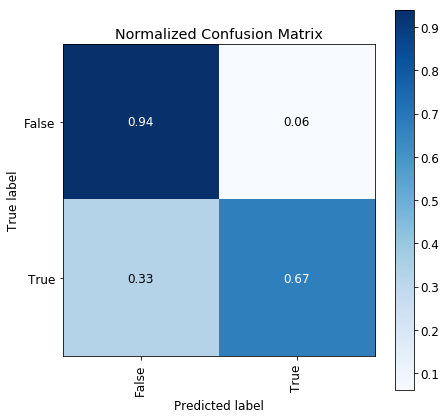

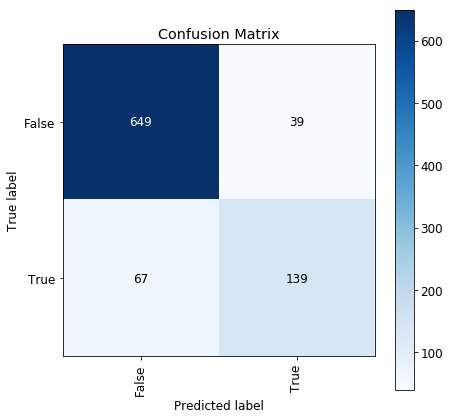

In [21]:
import matplotlib.pyplot as plt
import scikitplot as skplt

# fig = plt.figure(figsize=(7,20))
# gs = fig.add_gridspec(2, 1)


skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True , figsize=(7,7),  x_tick_rotation=90)
plt.savefig("confusionmatrix_normalised.jpg", bbox_inches='tight')

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], figsize=(7,7), normalize=False, x_tick_rotation=90 )
plt.savefig("confusionmatrix_unnormalised.jpg", bbox_inches='tight')




In [22]:
# from sklearn.metrics import accuracy_score, accuracy_score,recall_score


# interactions = df["class"].unique()
# interactions.sort()
# #fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
# fig = plt.figure(figsize=(20,20))
# gs = fig.add_gridspec(3, 3)
# #ax = fig.add_axes([0,0,1,1])
# i = 0
# avg = 'macro'
# for interaction in interactions:
#     r = i//3
#     c= i % 3
#     df_interaction_type = df.query("predicted == '{}'".format(interaction))
#     if df_interaction_type.shape[0] == 0: continue
#     ax1 = fig.add_subplot(gs[r, c])
    


#     f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"],average=avg, sample_weight=None)  
#     accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
#     precision= precision_score(df_interaction_type["actual"], df_interaction_type["predicted"], average=avg,sample_weight=None)
#     recall = recall_score(df_interaction_type["actual"], df_interaction_type["predicted"], average=avg,sample_weight=None)
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: \nPrecision {}, Recall {} \nF-score {}".format(interaction,  round(precision*100, 2),round(recall*100, 2), round(f1*100, 2)), ax= ax1)
    
# #     ax2 = fig.add_subplot(gs[i, 1])
# #     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


#     i += 1
#     #break

# plt.savefig("confusionmatrix_.jpg", bbox_inches='tight')
# plt.show()
    
    


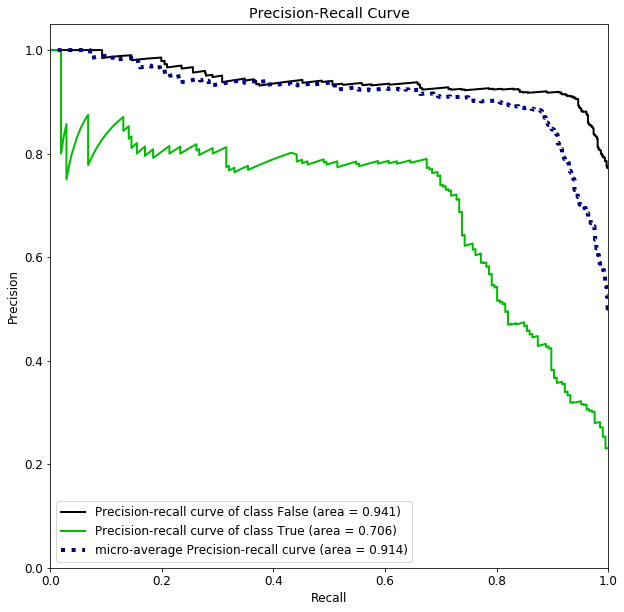

In [23]:


skplt.metrics.plot_precision_recall(df["actual"], df[keys], figsize=(10,10))

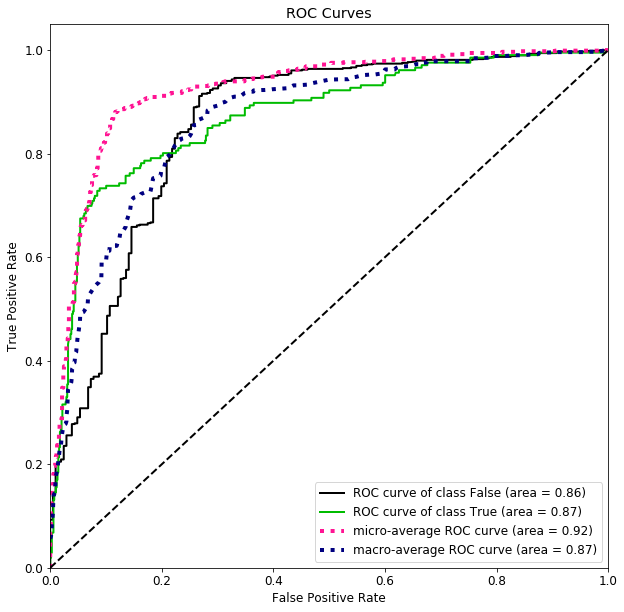

In [24]:

skplt.metrics.plot_roc(df["actual"], df[keys], figsize=(10,10))

## Training / Validation epoch fit

In [27]:
df_train_fit["score"] =df_train_fit["score"]* 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
38,38,0.897991,9987.910143
32,32,1.240311,9983.911241
44,44,0.899853,9983.898847
39,39,0.879323,9983.898847
42,42,0.868681,9983.886418
41,41,0.895303,9983.886418
36,36,0.920220,9983.886418
37,37,1.096133,9983.873954
24,24,1.969661,9979.896781
33,33,1.446311,9979.881310


In [29]:
df_val_fit["score"] =df_val_fit["score"]* 100


df_val_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
23,23,43.315627,83.083815
12,12,32.924648,82.823337
33,33,41.870604,82.532731
41,41,45.744951,82.268254
43,43,49.297639,82.207657
22,22,42.464401,82.005549
20,20,37.656112,82.005549
19,19,34.510314,81.830764
15,15,38.225885,81.794528
44,44,43.496057,81.623464


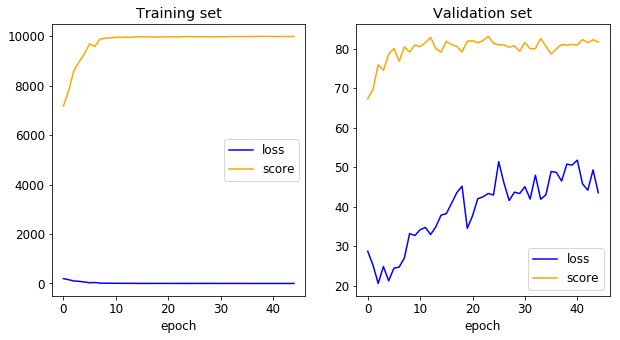

In [30]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color="orange")
ax[0].set_title("Training set")
#ax[0].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))

df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color ="orange")
ax[1].set_title("Validation set")
#ax[1].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))



plt.show()

### Threshold 

In [31]:
threshold = .00
key = keys[0]
df_trues = df.query("predicted_confidence >  {} and predicted == 'acetylation'".format(threshold))
print(df_trues.shape)

from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

f1 = f1_score(df_trues["actual"], df_trues["predicted"], average="macro")  
accuracy = accuracy_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)
precision = precision_score(df_trues["actual"], df_trues["predicted"], average="macro", sample_weight=None)
recall = recall_score(df_trues["actual"], df_trues["predicted"], average="macro", sample_weight=None)



print("The F1 score is {} and the accuracy is {}, precision {}, recall {}".format(f1, accuracy, precision, recall))

(0, 25)
The F1 score is nan and the accuracy is nan, precision nan, recall nan


/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
interactions = df_trues["interactionType"].unique()
#fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
fig = plt.figure(figsize=(40,40))
gs = fig.add_gridspec(7, 1)
#ax = fig.add_axes([0,0,1,1])
i = 0
for interaction in interactions:
    print(interaction)
    df_interaction_type = df_trues.query("interactionType == '{}'".format(interaction))
    ax1 = fig.add_subplot(gs[i, 0])
    


    f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"], average='macro')  
    accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax1)
    
#     ax2 = fig.add_subplot(gs[i, 1])
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


    i += 1
    #break

plt.savefig("confusionmatrix_threshold.jpg", bbox_inches='tight')
    

<Figure size 2880x2880 with 0 Axes>

## Filter uniprot not in train

In [36]:
df_train = pd.read_json('train_unique_pub_v6_less_negative.json')

In [37]:
df_train['participant1Id'].values.tolist()[0:10]

['O43293-1',
 'O43293-2',
 'O60934',
 'P53235',
 'P51617',
 'Q9NWZ3',
 'P51617',
 'Q9H0H5',
 'Q9H0H5',
 'Q9H0H5']

In [38]:
train_uniprot = set(df_train['participant1Id'].values.tolist()).union(set(df_train['participant2Id'].values.tolist()))

In [39]:
df_filtered_uniprot =df[ df.apply(lambda r : r['participant2Id'] in train_uniprot and  r['participant1Id'] in train_uniprot , axis=1)]

In [40]:
df_filtered_uniprot.shape

(454, 25)

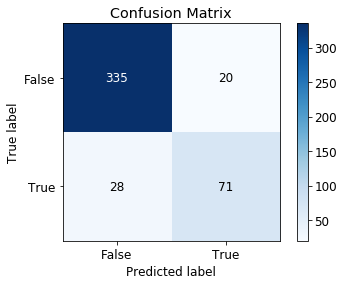

In [41]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], normalize=False )
plt.show()

In [42]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], sample_weight=None)  
accuracy = accuracy_score(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))




The F1 score is 0.7473684210526317 and the accuracy is 0.8942731277533039


In [ ]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df_filtered_missing_uniprot["actual"], df_filtered_missing_uniprot["predicted"], sample_weight=None)  
accuracy = accuracy_score(df_filtered_missing_uniprot["actual"], df_filtered_missing_uniprot["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))

## Variation Bert

In [44]:
#precision, recall, fscore
val_scores = {
    "ppi-bert-untype-2019-11-05-08-14-14-416-copy-3/algo-1-1573202144":[0.804347826,0.704761905,0.751269036],
    "ppi-bert-untype-2019-11-05-08-14-14-416-copy-2/algo-1-1573202128": [0.694736842,0.628571429,0.66],
    "ppi-bert-untype-2019-11-05-08-14-14-416-copy-11-08/algo-1-1573202119":[0.752293578,0.780952381,0.76635514],
    "ppi-bert-untype-2019-11-05-08-14-14-416-copy-5/algo-1-1573264923": [0.7346938775510204, 0.6857142857142857, 0.7093596059113301],
    "ppi-bert-untype-2019-11-05-08-14-14-416-copy-6/algo-1-1573264942":[0.75, 0.7714285714285715, 0.7605633802816902],
    "ppi-bert-untype-2019-11-05-08-14-14-416-copy-7/algo-1-1573264962": [0.7217391304347827, 0.7904761904761904, 0.7545454545454545],
    "ppi-bert-untype-2019-11-05-08-14-14-416-copy-8/algo-1-1573264983": [0.7373737373737373, 0.6952380952380952, 0.7156862745098039],
    "ppi-bert-untype-2019-11-05-08-14-14-416-copy-9/algo-1-1573264997":[0.75, 0.6857142857142857, 0.7164179104477612],
    "ppi-bert-untype-2019-11-05-08-14-14-416-copy-10/algo-1-1573265016":[0.7155963302752294, 0.7428571428571429, 0.7289719626168223],
    "ppi-bert-untype-2019-11-05-08-14-14-416/algo-1-1572941791":[0.7155963302752294, 0.7428571428571429, 0.7289719626168223]
}

In [45]:
import pandas as pd

def convert_to_df(scores : dict):
    score_formatted = []
    for k, v in scores.items():
        p,r,f1 = v[0], v[1], v[2]
        score_formatted.append ({"key":k, "Precision": p*100, "Recall":r*100, "F1-score": f1*100})
    return pd.DataFrame(score_formatted)
    

In [46]:
df_val_scores = convert_to_df(val_scores)

In [47]:
df_val_scores.describe()

,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000
mean,72.921407,73.763777,72.285714
std,3.166138,2.989670,5.147362
min,66.000000,69.473684,62.857143
25%,71.586918,71.713203,68.809524
50%,72.897196,73.603381,72.380952
75%,75.372635,75.000000,76.428571
max,76.635514,80.434783,79.047619


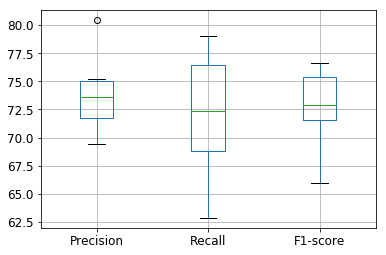

In [48]:
df_val_scores[["Precision", "Recall", "F1-score"]].boxplot()

In [66]:
%%time 

s3_model_paths = []
for k in val_scores:
    job_name = k.split("/")[0] 
    s3_path = s3_model_path_format.format(job_name)
    s3_model_paths.append(s3_path)

df_test_scores =  get_all_scores(s3_model_paths)

CPU times: user 2.14 s, sys: 221 ms, total: 2.36 s
Wall time: 1min 3s


In [67]:
df_test_scores.describe()

,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000
mean,71.759196,79.486314,65.679612
std,2.816175,2.668999,5.213521
min,65.306122,77.005348,54.368932
25%,71.172793,77.980071,63.470874
50%,72.229248,78.135853,66.019417
75%,73.260801,80.904512,68.567961
max,75.810474,85.256410,73.786408


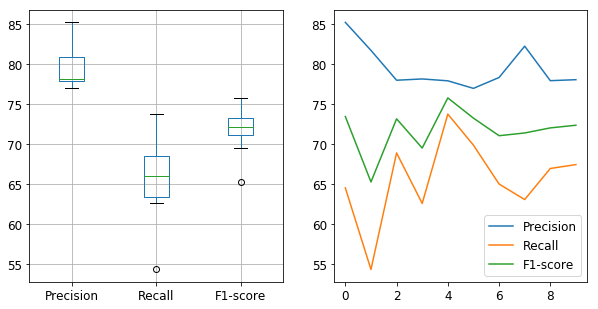

In [79]:

fig, ax = plt.subplots(1,2, figsize=(10, 5))

df_test_scores[["Precision", "Recall", "F1-score"]].boxplot(ax=ax[0])
df_test_scores[["Precision", "Recall", "F1-score"]].plot(ax = ax[1])

plt.savefig("score_variation.jpg", bbox_inches='tight')

